# Imports and Functions

In [1]:
import pg8000
import pandas as pd    
import os, re
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from allensdk.core.nwb_data_set import NwbDataSet
import allensdk.ephys.ephys_features as aef
import allensdk.ephys.extract_cell_features as ecf
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
#from research_ops_tools.lims2_funcs import get_lims_dataframe
#from allensdk.internal.core.lims_utilities import linux_to_windows

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
from sklearn.preprocessing import Imputer

In [3]:
#!pip install -U seaborn
#!pip install -U sklearn

In [4]:
#code from Agata
#these are nice functions to open LIMS, make a query and then close LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        
        #THESE ARE IMPORTANT!!!!!!
        #Every query needs to be closed when done
        cursor.close()             
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

# Culture

In [5]:
#c = raw_input('cell name 1: ')
#d = raw_input('cell name 2: ')

q = """
SELECT cell.patched_cell_container, cell.name,
cell.id,
SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) AS container_date,
ef.*
FROM specimens cell 
JOIN ephys_roi_results err ON cell.ephys_roi_result_id = err.id
JOIN projects proj ON cell.project_id = proj.id
LEFT JOIN ephys_features ef on ef.specimen_id = cell.id
WHERE SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) BETWEEN '190101' AND '200000'
AND proj.code = 'hIVSCC-METc'"""

df1 = get_lims_dataframe(q)
df1
#AND cell.name = '{}'
#AND cell.name = '{}' OR cell.name = '{}'
#.format(c)

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,f_i_curve_slope,created_at,peak_t_long_square,patched_cell_container,latency,fast_trough_v_long_square,upstroke_downstroke_ratio_long_square,trough_v_ramp,peak_v_long_square,adaptation
0,13.388912,1.819779,819205547.0,None,-26.335417,35.643749,1.663914,0.257020,2019-02-06 21:15:28.937910,3.791213,...,0.440000,2019-02-06 21:06:38.209258,0.77122,PXS4_190125_351_A01,0.03586,-56.693748,1.645211,-56.941666,33.431248,0.005169
1,8.359153,1.682270,819205509.0,None,-27.491667,30.456249,1.548367,0.308440,2019-02-06 21:15:41.840076,3.684700,...,0.760000,2019-02-06 21:06:48.794575,0.56042,PXS4_190125_352_A01,0.01128,-55.274998,1.543108,-55.116665,32.431248,0.004595
2,18.784336,2.647530,819205844.0,None,-42.560417,26.225000,2.651446,0.428155,2019-02-06 21:15:59.792092,1.085747,...,0.685714,2019-02-06 21:07:09.997064,0.54622,PXS4_190125_353_A01,0.01154,-65.893745,2.636752,-66.116669,28.225000,0.002489
3,17.850683,4.734689,819206039.0,None,-12.678124,-17.806250,3.971338,0.028632,2019-02-06 21:16:55.499342,4.277853,...,0.100000,2019-02-06 21:08:27.719359,0.60360,PXS4_190125_354_A01,0.05118,-42.625000,2.810915,-29.796875,9.025000,0.262256
4,10.288262,1.943297,819205711.0,None,-17.768749,30.981249,1.101951,0.421515,2019-02-06 21:15:43.198877,6.707287,...,0.485106,2019-02-06 21:06:46.468091,0.96372,PXS4_190125_355_A01,0.02712,-51.875000,1.126817,-51.854168,24.074999,0.008538
5,13.923525,1.777723,819205634.0,None,-21.091667,40.827084,1.461732,0.296505,2019-02-06 21:15:53.914215,5.472540,...,0.354310,2019-02-06 21:06:57.174703,0.96818,PXS4_190125_356_A01,0.01382,-52.487499,1.458961,-53.381252,33.437500,-0.013303
6,14.842336,2.370573,819205931.0,None,-33.329166,32.818748,2.108296,0.437803,2019-02-06 21:15:45.674092,1.937380,...,0.385714,2019-02-06 21:07:02.245281,0.53342,PXS4_190125_357_A01,0.01648,-56.487499,2.388311,-58.637497,35.149998,0.011303
7,13.919652,2.146099,819205874.0,None,-34.279163,39.256248,2.510925,0.220360,2019-02-06 21:16:10.281504,2.721987,...,0.215000,2019-02-06 21:07:20.947972,0.63106,PXS4_190125_358_A01,0.03006,-57.537498,2.082513,-63.020832,33.512501,0.021134
8,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,PXS4_190125_359_A01,NaN,NaN,NaN,NaN,NaN,NaN
9,19.908757,1.881894,819235798.0,None,-29.189583,36.228748,1.818622,0.482347,2019-02-06 22:11:39.805220,2.082060,...,0.335000,2019-02-06 22:11:39.805220,0.58710,PXS4_190128_351_A01,0.03018,-53.243748,1.996993,-53.204163,37.318748,0.021266


# Acute

In [6]:
#c = raw_input('cell name 1: ')
#d = raw_input('cell name 2: ')

q = """
SELECT cell.patched_cell_container, cell.name,
cell.id,
SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) AS container_date,
ef.*
FROM specimens cell 
JOIN ephys_roi_results err ON cell.ephys_roi_result_id = err.id
JOIN projects proj ON cell.project_id = proj.id
LEFT JOIN ephys_features ef on ef.specimen_id = cell.id
WHERE SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) BETWEEN '171001' AND '200000'
AND proj.code = 'hIVSCC-MET'"""

df = get_lims_dataframe(q)
df
#AND cell.name = '{}'
#AND cell.name = '{}' OR cell.name = '{}'
#.format(c)

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,f_i_curve_slope,created_at,peak_t_long_square,patched_cell_container,latency,fast_trough_v_long_square,upstroke_downstroke_ratio_long_square,trough_v_ramp,peak_v_long_square,adaptation
0,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_401_A01,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_402_A01,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_403_A01,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P8S4_171013_355_A01,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_404_A01,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_053_A01,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_054_A01,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_055_A01,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_056_A01,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P8S4_171017_351_A01,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df1.columns

Index([u'tau', u'upstroke_downstroke_ratio_short_square',
       u'thumbnail_sweep_id', u'has_delay', u'threshold_v_ramp',
       u'peak_v_short_square', u'upstroke_downstroke_ratio_ramp', u'sag',
       u'updated_at', u'threshold_t_ramp', u'slow_trough_v_ramp', u'vrest',
       u'has_pause', u'trough_t_ramp', u'trough_v_long_square',
       u'threshold_t_short_square', u'id', u'trough_t_short_square',
       u'fast_trough_v_ramp', u'trough_t_long_square',
       u'slow_trough_v_long_square', u'rheobase_sweep_id', u'peak_t_ramp',
       u'has_burst', u'slow_trough_t_long_square', u'threshold_v_long_square',
       u'fast_trough_t_long_square', u'ri', u'threshold_t_long_square',
       u'threshold_v_short_square', u'avg_isi', u'vm_for_sag', u'specimen_id',
       u'threshold_i_long_square', u'threshold_i_short_square',
       u'slow_trough_t_ramp', u'peak_v_ramp', u'fast_trough_v_short_square',
       u'fast_trough_t_short_square', u'fast_trough_t_ramp', u'container_date',
       u'slow

In [8]:
#df.to_csv("human_acute_ephys_features.csv")

In [9]:
#df1.to_csv("human_culture_ephys_features.csv")

# Merging dataframes with shiny

In [10]:
shiny = pd.read_csv('human_shiny1.csv')
#shiny = pd.read_csv("Z:\IVSCC_KPIs\shiny_LIMS.csv") column EF
recent_shiny = pd.read_csv('shiny190515.csv')
shiny_frames = [shiny, recent_shiny]
shiny = pd.concat(shiny_frames)
shiny['class'].value_counts()

Excitatory    508
VIP            97
PVALB          94
LAMP5          92
SST            37
Name: class, dtype: int64

In [11]:
culture_df = pd.merge(left = df1, 
                    right = shiny, 
                    left_on = 'name', #ephys
                    right_on = 'cell_name_label', #shiny
                    how = 'left')
culture_df

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,contaminationType_color,seurat_cluster_label,caret_cluster_label,caret_correlation_label,seurat_cluster_id,seurat_cluster_color,caret_cluster_id,caret_cluster_color,caret_correlation_id,caret_correlation_color
0,13.388912,1.819779,819205547.0,None,-26.335417,35.643749,1.663914,0.257020,2019-02-06 21:15:28.937910,3.791213,...,#85CC3D,1,Inh L5-6 SST MIR548F2,0.176,2.0,#CC623D,66.0,#992E53,72.0,#8787C8
1,8.359153,1.682270,819205509.0,None,-27.491667,30.456249,1.548367,0.308440,2019-02-06 21:15:41.840076,3.684700,...,#85CC3D,1,Inh L4-6 PVALB SULF1,0.216,2.0,#CC623D,60.0,#990085,92.0,#A3A3D5
2,18.784336,2.647530,819205844.0,None,-42.560417,26.225000,2.651446,0.428155,2019-02-06 21:15:59.792092,1.085747,...,#85CC3D,16,Inh L3-5 SST ADGRG6,0.348,9.0,#45994C,54.0,#6F2E99,158.0,#F9F9FC
3,17.850683,4.734689,819206039.0,None,-12.678124,-17.806250,3.971338,0.028632,2019-02-06 21:16:55.499342,4.277853,...,#179999,0,Inh L4-6 SST B3GAT2,0.058,1.0,#FF7373,61.0,#FF73E1,13.0,#2E2EA0
4,10.288262,1.943297,819205711.0,None,-17.768749,30.981249,1.101951,0.421515,2019-02-06 21:15:43.198877,6.707287,...,#85CC3D,16,Inh L1-3 SST CALB1,0.232,9.0,#45994C,33.0,#459987,100.0,#AEAEDA
5,13.923525,1.777723,819205634.0,None,-21.091667,40.827084,1.461732,0.296505,2019-02-06 21:15:53.914215,5.472540,...,#179999,1,Inh L5-6 SST MIR548F2,0.222,2.0,#CC623D,66.0,#992E53,95.0,#A7A7D7
6,14.842336,2.370573,819205931.0,None,-33.329166,32.818748,2.108296,0.437803,2019-02-06 21:15:45.674092,1.937380,...,#179999,0,Inh L5-6 PVALB LGR5,0.064,1.0,#FF7373,64.0,#FF0085,16.0,#3434A2
7,13.919652,2.146099,819205874.0,None,-34.279163,39.256248,2.510925,0.220360,2019-02-06 21:16:10.281504,2.721987,...,#85CC3D,19,Inh L2-6 LAMP5 CA1,0.706,12.0,#009985,52.0,#6F00FF,272.0,#FF4040
8,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#85CC3D,16,Inh L1-3 SST CALB1,0.296,9.0,#45994C,33.0,#459987,132.0,#D8D8ED
9,19.908757,1.881894,819235798.0,None,-29.189583,36.228748,1.818622,0.482347,2019-02-06 22:11:39.805220,2.082060,...,#85CC3D,16,Inh L1-3 SST CALB1,0.406,9.0,#45994C,33.0,#459987,187.0,#FFE1E1


In [12]:
acute_df = pd.merge(left = df, 
                    right = shiny, 
                    left_on = 'name', #ephys
                    right_on = 'cell_name_label', #shiny
                    how = 'left')
acute_df.head()

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,contaminationType_color,seurat_cluster_label,caret_cluster_label,caret_correlation_label,seurat_cluster_id,seurat_cluster_color,caret_cluster_id,caret_cluster_color,caret_correlation_id,caret_correlation_color
0,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#FF7373,ZZ_Missing,ZZ_Missing,0.000,23.0,#CC1F4C,69.0,#99454C,1.0,#00008B
1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#179999,ZZ_Missing,ZZ_Missing,0.000,23.0,#CC1F4C,69.0,#99454C,1.0,#00008B
2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#179999,1,Inh L4-6 PVALB SULF1,0.222,2.0,#CC623D,60.0,#990085,95.0,#A7A7D7
3,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#179999,ZZ_Missing,ZZ_Missing,0.000,23.0,#CC1F4C,69.0,#99454C,1.0,#00008B
4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,#179999,ZZ_Missing,ZZ_Missing,0.000,23.0,#CC1F4C,69.0,#99454C,1.0,#00008B


In [13]:
#culture_df.to_csv("human_culture_ephys_features_shiny.csv")

In [14]:
#acute_df.to_csv("human_acute_ephys_features_shiny.csv")

# Lindsay only dataframe

In [15]:
lindsay_acute= acute_df[acute_df['patched_cell_container'].str.contains('_35|_36|_37')]
lindsay_acute.tail()

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,contaminationType_color,seurat_cluster_label,caret_cluster_label,caret_correlation_label,seurat_cluster_id,seurat_cluster_color,caret_cluster_id,caret_cluster_color,caret_correlation_id,caret_correlation_color
1157,33.975722,1.959654,868155077.0,None,-39.447914,27.006250,2.358866,0.075989,2019-05-15 01:05:04.257199,1.355640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1160,31.335994,3.309244,868154640.0,None,-29.985418,44.093750,3.239231,0.156107,2019-05-15 01:04:42.668237,5.471207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1168,32.635667,4.650881,868262747.0,None,-34.350002,53.293751,4.593447,0.076178,2019-05-15 04:49:55.754148,3.826420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1172,21.165946,2.403651,868262554.0,None,-31.666666,45.062500,2.392587,0.218335,2019-05-15 04:50:05.873745,2.469073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1173,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
lindsay_culture = culture_df[culture_df['patched_cell_container'].str.contains('_35|_36|_37')]
lindsay_culture['class'].head()

0    PVALB
1    PVALB
2      SST
3      NaN
4      SST
Name: class, dtype: object

# Plotting

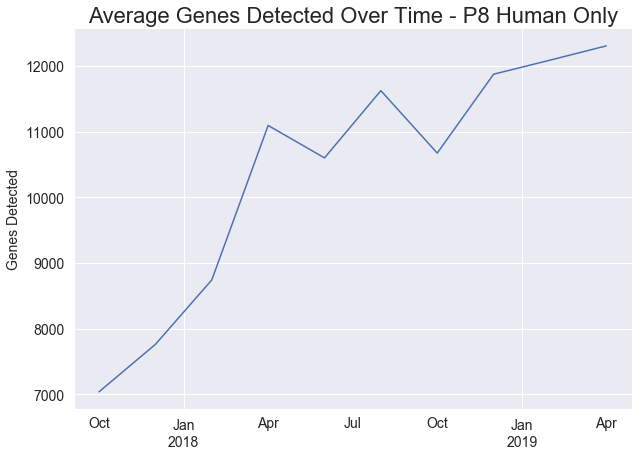

In [17]:
lindsay_acute = lindsay_acute[lindsay_acute['postPatch_label'] == 'nucleus_present']
lindsay_acute["container_date"] = pd.to_datetime(lindsay_acute["container_date"], format = '%y%m%d', errors = 'coerce')
lindsay_acute.sort_values("container_date", axis = 0, inplace = True)
lindsay_acute.set_index("container_date", inplace=True)
ps3 = lindsay_acute.groupby(pd.TimeGrouper(freq="2m"))["genes_label"].mean()
ps3.plot(figsize=(10,7), fontsize= 14)
plt.title("Average Genes Detected Over Time - P8 Human Only", fontsize= 22, loc = "center")
plt.ylabel("Genes Detected", fontsize= 14)
plt.xlabel("")
sns.despine()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/genes_detected_over_time")

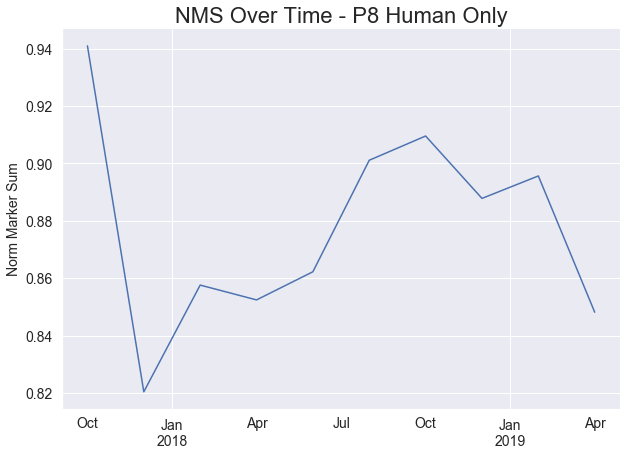

In [18]:
ps4 = lindsay_acute.groupby(pd.TimeGrouper(freq="2m"))["marker_sum_norm_label"].mean()
ps4.plot(figsize=(10,7), fontsize= 14)
plt.title("NMS Over Time - P8 Human Only", fontsize= 22, loc = "center")
plt.ylabel("Norm Marker Sum", fontsize= 14)
plt.xlabel("")
sns.despine()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/NMS_over_time")

In [19]:
lindsay_culture = lindsay_culture[lindsay_culture['class'].notnull()] 



In [20]:
color_palette=dict(PVALB="mediumpurple", SST="coral", LAMP5='turquoise', Excitatory= 'gold', VIP= 'royalblue')
color_palette2=["mediumpurple","coral",'turquoise','gold','royalblue']

In [21]:
classes = ['PVALB','SST','LAMP5','Excitatory','VIP']

In [22]:
acute_df['fast_ahp']= acute_df['threshold_v_short_square'] - acute_df['fast_trough_v_short_square']
acute_df['fast_ahp']

culture_df['fast_ahp']= culture_df['threshold_v_short_square'] - culture_df['fast_trough_v_short_square']
acute_df[acute_df['class']=='SST']['name']

6         H17.06.013.12.05.02
29        H17.26.003.11.14.01
64        H17.06.015.11.06.06
223       H18.03.005.11.06.05
277       H18.03.008.11.15.07
290       H18.03.009.11.16.02
384    H18.03.012.11.07.02.02
446    H18.26.404.11.05.01.01
499    H18.03.313.11.15.01.04
620    H18.03.316.11.14.01.01
668    H18.03.317.12.09.01.04
682    H18.06.366.15.21.01.03
865    H18.06.371.12.04.01.01
992    H19.03.305.11.10.01.10
Name: name, dtype: object

In [23]:
sst = pd.read_csv('extra_sst.csv')
new = [sst,acute_df]
extra_sst_df = pd.concat(new)
extra_sst_df

,Class_color,Class_id,Class_label,Depth_from_Pia_microns_color,Depth_from_Pia_microns_id,Depth_from_Pia_microns_label,Ephys_time_color,Ephys_time_id,Ephys_time_label,L23_cell_depth_color,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,updated_at,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
0,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFADAD,64.0,67.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFFDFD,21.0,24.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#17994B,3.0,noclass,#00008B,1.0,0.0,#EBEBF5,15.0,18.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#17994B,3.0,noclass,#00008B,1.0,0.0,#FF9A9A,83.0,86.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#17994B,3.0,noclass,#00008B,1.0,0.0,#F2F2F9,17.0,20.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFC7C7,45.0,48.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFB4B4,58.0,61.0,#00008B,...,NaN,-52.498441,NaN,NaN,NaN,2.002569,NaN,NaN,NaN,-56.389000
7,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFCACA,43.0,46.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFCACA,43.0,46.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFF9F9,22.0,25.0,#00008B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
culture_df[culture_df['class'] == 'SST']['name'].count()

14

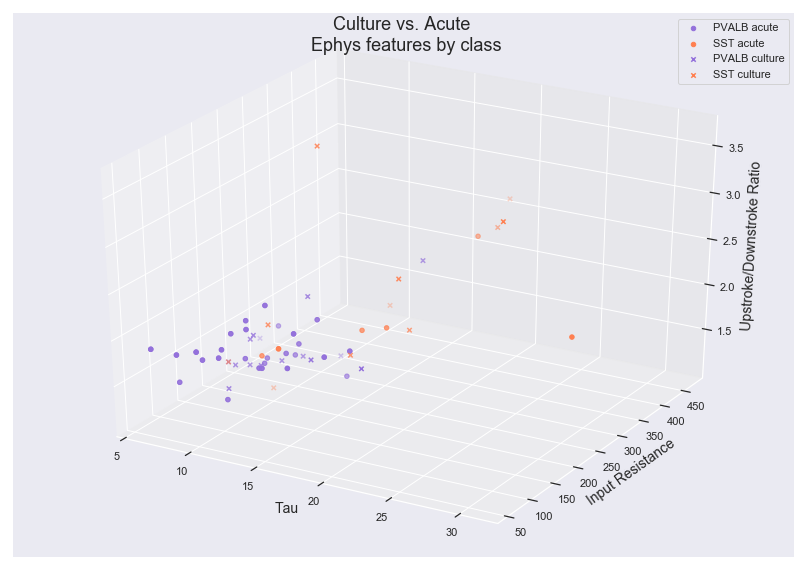

In [25]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(14,10))
ax = plt.axes(projection='3d')
for i in range(2):
    df = extra_sst_df[extra_sst_df['class'] == classes[i]]
    x=df['tau']
    y=df['ri']
    z=df['upstroke_downstroke_ratio_long_square']
    ax.scatter3D(x,y,z,color=color_palette2[i], label = classes[i] + ' acute',marker='o')
for i in range(2):
    df = culture_df[culture_df['class'] == classes[i]]
    x=df['tau']
    y=df['ri']
    z=df['upstroke_downstroke_ratio_long_square']
    ax.scatter3D(x,y,z,color=color_palette2[i], label = classes[i] + ' culture',marker='x')
plt.title('Culture vs. Acute \n Ephys features by class', fontsize=18)
#plt.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('Tau', fontsize=14)
ax.set_ylabel('Input Resistance', fontsize=14)
ax.set_zlabel('Upstroke/Downstroke Ratio', fontsize=14)
ax.legend()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/acute_vs_culture_3D", dpi=300)

In [26]:
lindsay_culture['project']= 'culture'
lindsay_acute['project']= 'acute'

culture_df['project']= 'culture'
acute_df['project']= 'acute'


In [27]:
lindsay_acute['project'].head()

container_date
2017-10-17    acute
2017-11-27    acute
2017-11-27    acute
2017-12-05    acute
2017-12-05    acute
Name: project, dtype: object

In [28]:
extra_sst_df2= extra_sst_df[extra_sst_df['class'] =='SST']
extra_sst_df2['project'] = 'acute'

In [29]:
#combine acute and culture frames into one dataframe
frames = [lindsay_acute, lindsay_culture]
frames2 = [acute_df, culture_df, extra_sst_df2]

lindsay_all = pd.concat(frames)
all_df = pd.concat(frames2)

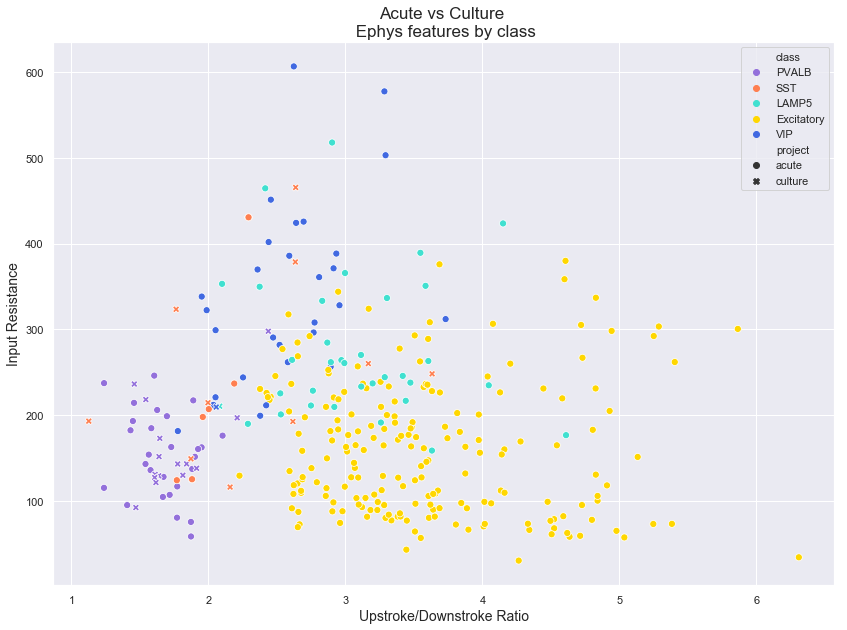

In [30]:
fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(x="upstroke_downstroke_ratio_long_square", y="ri", data=all_df, hue='class', legend='full', style='project', palette= color_palette,s=50)
plt.title("Acute vs Culture \n Ephys features by class", fontsize= 17, loc = "center")
plt.ylabel("Input Resistance", fontsize= 14)
plt.xlabel("Upstroke/Downstroke Ratio", fontsize= 14)
#plt.gcf().subplots_adjust(top=0.92)
#plt.ylim(50, 600)
#plt.xlim(1, 6)
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/acute_vs_culture_ephys_features")

In [96]:
features1 = ['tau', 'upstroke_downstroke_ratio_short_square',
       'has_delay', 'threshold_v_ramp',
       'peak_v_short_square', 'upstroke_downstroke_ratio_ramp', 'sag',
       'threshold_t_ramp', 'slow_trough_v_ramp', 'vrest',
       'has_pause', 'trough_t_ramp', 'trough_v_long_square',
       'threshold_t_short_square', 'trough_t_short_square',
       'fast_trough_v_ramp', 'trough_t_long_square',
       'slow_trough_v_long_square', 'peak_t_ramp',
       'has_burst', 'slow_trough_t_long_square', 'threshold_v_long_square',
       'fast_trough_t_long_square', 'ri', 'threshold_t_long_square',
       'threshold_v_short_square', 'avg_isi', 'vm_for_sag',
       'threshold_i_long_square', 'threshold_i_short_square',
       'slow_trough_t_ramp', 'peak_v_ramp', 'fast_trough_v_short_square',
       'fast_trough_t_short_square', 'fast_trough_t_ramp',
       'slow_trough_t_short_square', 'threshold_i_ramp',
       'slow_trough_v_short_square', 'peak_t_short_square',
       'trough_v_short_square', 'f_i_curve_slope',
       'peak_t_long_square', 'latency',
       'fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square',
       'trough_v_ramp', 'peak_v_long_square', 'adaptation']

features =['ri','upstroke_downstroke_ratio_long_square', 'tau']

In [97]:
all_df4 = all_df.dropna(subset= features+['class'])

In [98]:
all_df2 = all_df[all_df['class'].notnull()]
all_df3 = all_df2[all_df2['ri'].notnull()]
all_df4['class']

180    Excitatory
326    Excitatory
327    Excitatory
328    Excitatory
330    Excitatory
331    Excitatory
333    Excitatory
335    Excitatory
336    Excitatory
337    Excitatory
338         LAMP5
339    Excitatory
340    Excitatory
341    Excitatory
342    Excitatory
343    Excitatory
344    Excitatory
345    Excitatory
347    Excitatory
348    Excitatory
349    Excitatory
350    Excitatory
351         LAMP5
354         PVALB
355         PVALB
356    Excitatory
358    Excitatory
359    Excitatory
366    Excitatory
367           VIP
          ...    
9             SST
12          PVALB
14          PVALB
16            SST
17            SST
21          PVALB
22            SST
23            SST
25          PVALB
26            SST
27            SST
34          PVALB
35          PVALB
36          PVALB
37          PVALB
41            SST
42          PVALB
43          PVALB
44          PVALB
48            VIP
49          PVALB
54            SST
6             SST
29            SST
64        

In [99]:
x = all_df4.loc[:,features].values
y = all_df4.loc[:,['class']].values
x = StandardScaler().fit_transform(x)

In [100]:
pd.DataFrame(data = x, columns = features)

,ri,upstroke_downstroke_ratio_long_square,tau
0,-1.031331,0.561592,-0.772954
1,-0.872288,-0.257320,0.323253
2,-0.639959,0.178131,0.994135
3,-0.058358,0.088773,0.364179
4,-1.354096,2.018825,0.030421
5,-1.126446,0.529089,0.345700
6,-0.844221,0.578258,0.044065
7,-0.356175,-0.094541,0.276296
8,0.663575,1.149410,1.069355
9,-0.897236,-0.023663,0.279448


In [101]:
#imp = Imputer(strategy='mean',axis =0)
#scale= StandardScaler()
#x = scale.fit_transform(imp.fit_transform(x))

In [102]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2'])
#finalDf = pd.concat([principalDf, all_df[['class']]], axis=1)
principalDf

,principal component 1,principal component 2
0,-0.512187,-1.246301
1,-0.165686,-0.579845
2,0.661521,-0.535427
3,0.306270,-0.057891
4,0.886356,-2.184236
5,0.264125,-1.196348
6,0.151747,-1.011494
7,0.045007,-0.227372
8,1.681488,0.088381
9,-0.060918,-0.725031


In [103]:
all_df4

,Class_color,Class_id,Class_label,Depth_from_Pia_microns_color,Depth_from_Pia_microns_id,Depth_from_Pia_microns_label,Ephys_time_color,Ephys_time_id,Ephys_time_label,L23_cell_depth_color,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,updated_at,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
180,#17994B,3.0,noclass,#00008B,1.0,0.0,#FF9B9B,81.0,84.0,#00008B,...,0.505333,-47.093750,-51.437500,-46.479168,2019-05-24 20:09:48.303233,3.640477,3.360874,2.956715,-81.656250,-70.301851
326,#17994B,3.0,noclass,#FF6969,68.0,418.0,#FFF4F4,24.0,27.0,#2E2EA0,...,0.708540,-53.343750,-50.343750,-77.125000,2019-02-22 04:34:05.763170,2.856434,2.803748,2.891882,-88.593750,-76.359494
327,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFD5D5,37.0,40.0,#00008B,...,1.160240,-49.781250,-46.125000,-66.570312,2019-02-22 04:53:40.343304,3.273343,3.016996,2.892513,-83.187500,-67.354051
328,#17994B,3.0,noclass,#FF0505,204.0,1840.0,#FF9898,84.0,87.0,#FF0F0F,...,0.573443,-45.000000,-49.609375,-53.156250,2019-02-22 04:24:42.614608,3.187791,3.139565,2.993255,-88.218750,-67.272539
330,#17994B,3.0,noclass,#FF3F3F,132.0,771.0,#FFC7C7,45.0,48.0,#FF5F5F,...,0.629460,-56.812500,-50.218750,-72.429688,2019-02-22 04:35:28.736245,5.035659,4.601082,4.758533,-79.000000,-72.065987
331,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFD2D2,39.0,42.0,#00008B,...,0.663680,-53.968750,-53.187500,-72.487503,2019-02-22 04:54:03.256913,3.609357,3.326662,3.293653,-82.968750,-72.421063
333,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFC9C9,44.0,47.0,#00008B,...,0.637327,-58.937500,-57.718750,-71.333336,2019-02-22 04:35:03.498409,3.656432,3.710602,3.506689,-83.312500,-70.838734
335,#17994B,3.0,noclass,#FF5E5E,88.0,490.0,#FF9595,88.0,91.0,#FF9C9C,...,1.171372,-48.968750,-48.265625,-71.744789,2019-02-22 04:34:54.999560,3.012281,2.722512,2.687674,-91.000000,-71.796686
336,#17994B,3.0,noclass,#00008B,1.0,0.0,#FFB7B7,56.0,59.0,#00008B,...,1.065064,-59.656250,-61.156250,-69.849998,2019-02-22 04:34:51.195696,4.203265,4.595780,3.475678,-99.906250,-69.237574
337,#17994B,3.0,noclass,#FF6C6C,60.0,395.0,#FFC9C9,44.0,47.0,#FFD6D6,...,1.166950,-57.000000,-57.031250,-81.414062,2019-02-22 04:34:48.795726,3.080142,2.862320,2.912952,-93.281250,-81.320277


In [104]:
#finalDf = principalDf.join(all_df3[['class']])

all_df4.reset_index(drop=True, inplace=True)
principalDf.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, all_df4[['class']]], axis=1)
finalDf

,principal component 1,principal component 2,class
0,-0.512187,-1.246301,Excitatory
1,-0.165686,-0.579845,Excitatory
2,0.661521,-0.535427,Excitatory
3,0.306270,-0.057891,Excitatory
4,0.886356,-2.184236,Excitatory
5,0.264125,-1.196348,Excitatory
6,0.151747,-1.011494,Excitatory
7,0.045007,-0.227372,Excitatory
8,1.681488,0.088381,Excitatory
9,-0.060918,-0.725031,Excitatory


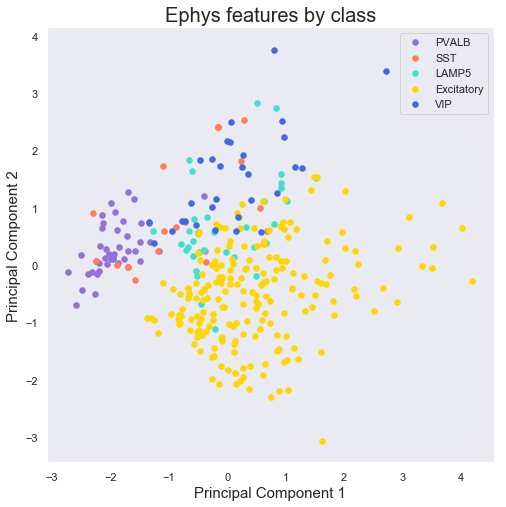

In [105]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Ephys features by class', fontsize = 20)

targets = ['PVALB','SST','LAMP5','Excitatory','VIP']
colors = ["mediumpurple","coral",'turquoise','gold','royalblue']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)
ax.legend(targets)
ax.grid()